In [1]:
!pip3 install tensorflow pandas numpy scikit-learn matplotlib seaborn stable-baselines3 gym==0.26.2 tqdm plotly notebook --quiet



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional, Lambda, BatchNormalization, Softmax, Multiply
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# 🔧 Fixed attention block
def attention_block_with_weights(x):
    attention = Dense(1, activation='tanh')(x)
    attention = Softmax(axis=1)(attention)
    context = Multiply()([x, attention])
    return context, attention

# ⚙️ Rebuild model
input_shape = (60, 12)
inp = Input(shape=input_shape)

x = Bidirectional(LSTM(128, return_sequences=True))(inp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x, _ = attention_block_with_weights(x)
x = Lambda(lambda x: K.sum(x, axis=1))(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

lstm_model = Model(inputs=inp, outputs=output)
lstm_model.compile(optimizer=Adam(0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ✅ Load weights
lstm_model.load_weights("best_lstm_attention_model.keras")
print("✅ LSTM model built and weights loaded successfully")


/Users/nil/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2025-04-20 02:03:00.010126: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-04-20 02:03:00.010143: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-20 02:03:00.010146: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-20 02:03:00.010163: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-20 02:03:00.010171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB me

✅ LSTM model built and weights loaded successfully


/Users/nil/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



📊 FINAL HYBRID REPORT
🔢 Total Trades: 1040
✅ Wins: 990
❌ Losses: 50
💸 Net PnL: ₹376,000


/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


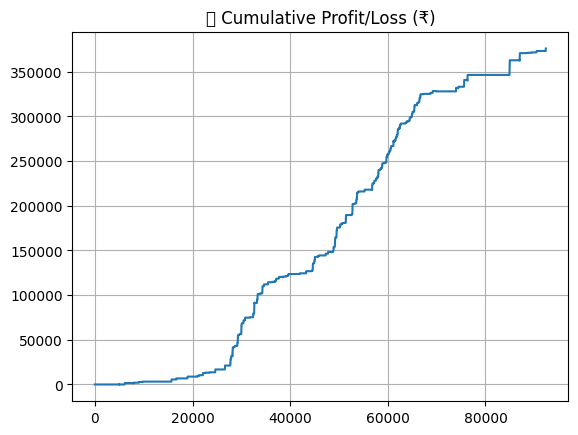

/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


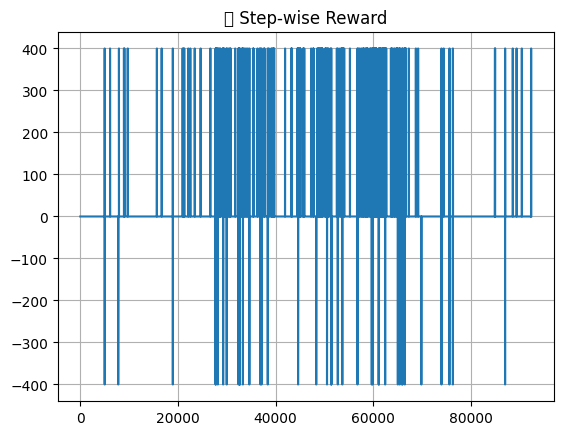


🧠 Confusion Matrix:
              precision    recall  f1-score   support

    No Trade       1.00      1.00      1.00      1040

    accuracy                           1.00      1040
   macro avg       1.00      1.00      1.00      1040
weighted avg       1.00      1.00      1.00      1040



/Users/nil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


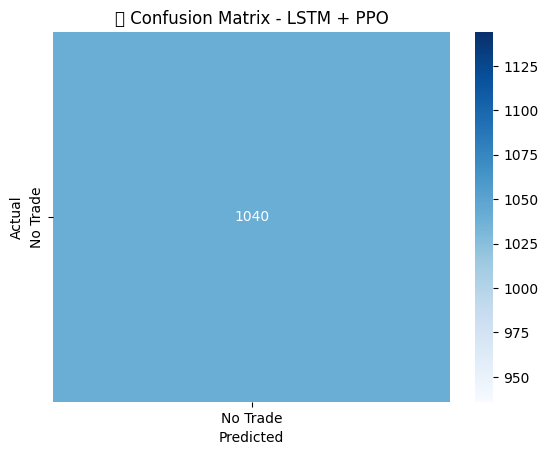

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO

# Load PPO models
ppo_ce = PPO.load("ppo_ce_model")
ppo_pe = PPO.load("ppo_pe_model")

# Load and preprocess data
df = pd.read_csv("ppo_ready_data_PPO.csv")
df = df.dropna().replace([np.inf, -np.inf], 0).reset_index(drop=True)

feature_cols = [col for col in df.columns if col not in ['label', 'confidence']]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], 0).fillna(0)

# Constants
SEQ_LEN = 60
BATCH_SIZE = 512
lot_size = 5
target = 80
stoploss = 40
conf_threshold = 0.85

# Generate sequences
X_live = []
for i in range(SEQ_LEN, len(df)):
    X_live.append(df[feature_cols].iloc[i-SEQ_LEN:i].values)
X_live = np.array(X_live)

# Predict LSTM signals in batches
pred_probs = []
for i in range(0, len(X_live), BATCH_SIZE):
    batch = X_live[i:i+BATCH_SIZE]
    batch_probs = lstm_model.predict(batch, verbose=0)
    pred_probs.append(batch_probs)
pred_probs = np.vstack(pred_probs)

signals = np.argmax(pred_probs, axis=1)
confidences = np.max(pred_probs, axis=1)

# Build DataFrame
df_eval = df.iloc[SEQ_LEN:].copy().reset_index(drop=True)
df_eval["lstm_signal"] = signals
df_eval["confidence"] = confidences

# Batch PPO evaluation
actions_taken = []
rewards = []
real_labels = []
predicted_labels = []

for i in range(len(df_eval)):
    signal = df_eval.loc[i, "lstm_signal"]
    confidence = df_eval.loc[i, "confidence"]
    features = df_eval.loc[i, feature_cols].values.astype(np.float32)

    if confidence < conf_threshold or signal == 0:
        actions_taken.append("No Trade")
        rewards.append(0)
        continue

    one_hot = [1, 0] if signal == 1 else [0, 1]
    obs = np.concatenate([features, one_hot, [confidence]]).reshape(1, -1)
    obs = np.nan_to_num(obs)

    if signal == 1:
        action, _ = ppo_ce.predict(obs)
        real_labels.append("Buy CE")
        predicted_labels.append("Buy CE" if action[0] == 0 else "Hold")
        reward = (target if action[0] == 0 else -stoploss * 2) * lot_size
    elif signal == 2:
        action, _ = ppo_pe.predict(obs)
        real_labels.append("Buy PE")
        predicted_labels.append("Buy PE" if action[0] == 0 else "Hold")
        reward = (target if action[0] == 0 else -stoploss * 2) * lot_size
    else:
        reward = 0

    actions_taken.append("Buy" if action[0] == 0 else "Hold")
    rewards.append(reward)

# Final report
df_eval["action"] = actions_taken
df_eval["reward"] = rewards
df_eval["real_label"] = real_labels + ["No Trade"] * (len(df_eval) - len(real_labels))
df_eval["predicted_label"] = predicted_labels + ["No Trade"] * (len(df_eval) - len(predicted_labels))

# Stats
total_trades = df_eval[df_eval["action"] != "No Trade"].shape[0]
wins = df_eval[df_eval["reward"] > 0].shape[0]
losses = df_eval[df_eval["reward"] < 0].shape[0]
total_pnl = df_eval["reward"].sum()

print("\n📊 FINAL HYBRID REPORT")
print(f"🔢 Total Trades: {total_trades}")
print(f"✅ Wins: {wins}")
print(f"❌ Losses: {losses}")
print(f"💸 Net PnL: ₹{int(total_pnl):,}")

# Charts
plt.plot(np.cumsum(df_eval["reward"]))
plt.title("📈 Cumulative Profit/Loss (₹)")
plt.grid(True)
plt.show()

plt.plot(df_eval["reward"])
plt.title("💵 Step-wise Reward")
plt.grid(True)
plt.show()

# Confusion matrix
filtered = df_eval[df_eval["action"] != "No Trade"]
true_labels = filtered["real_label"]
pred_labels = filtered["predicted_label"]

print("\n🧠 Confusion Matrix:")
print(classification_report(true_labels, pred_labels))

all_labels = sorted(list(set(true_labels) | set(pred_labels)))

cm = confusion_matrix(true_labels, pred_labels, labels=all_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_labels,
            yticklabels=all_labels)
plt.title("🧠 Confusion Matrix - LSTM + PPO")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


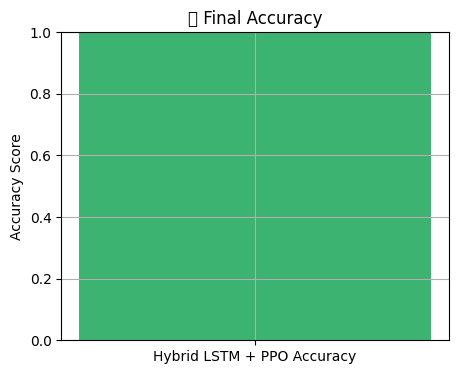

In [10]:
from sklearn.metrics import accuracy_score

# Accuracy for all trades where action was taken
filtered = df_eval[df_eval["action"] != "No Trade"]
acc = accuracy_score(filtered["real_label"], filtered["predicted_label"])

plt.figure(figsize=(5,4))
plt.bar(["Hybrid LSTM + PPO Accuracy"], [acc], color="mediumseagreen")
plt.ylim(0, 1)
plt.ylabel("Accuracy Score")
plt.title("✅ Final Accuracy")
plt.grid(True)
plt.show()


/var/folders/67/69v53fx92hq79bh10_0qb4zh0000gn/T/ipykernel_14819/1963056696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=precisions, palette="Blues_d")
/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


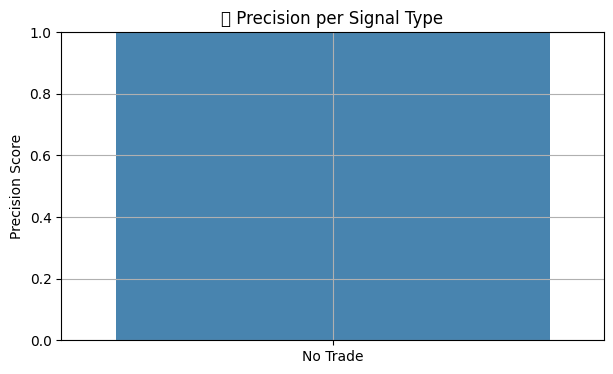

In [11]:
from sklearn.metrics import classification_report

report = classification_report(filtered["real_label"], filtered["predicted_label"], output_dict=True)

labels = list(report.keys())[:-3]  # Exclude avg/weighted keys
precisions = [report[label]["precision"] for label in labels]

plt.figure(figsize=(7,4))
sns.barplot(x=labels, y=precisions, palette="Blues_d")
plt.ylim(0, 1)
plt.ylabel("Precision Score")
plt.title("🎯 Precision per Signal Type")
plt.grid(True)
plt.show()
